In [1]:
# https://zhuanlan.zhihu.com/p/137571225
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
import torchvision
import matplotlib.pyplot as plt

In [ ]:
# 1.加载数据集
batch_size = 512  #每个batch多少张图片
#读取训练集
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('data',  #数据存储路径，如果不存在下载后会存到此路径
                               train=True, download=True,  #如果本地不存在，则下载数据
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),  #数据类型转为tensor格式
                                   torchvision.transforms.Normalize(  #将数据Normalize处理，类似归一化
                                       (0.1307,), (0.3081,))
                               ])),
    batch_size=batch_size, shuffle=True)
#读取测试集
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('data', train=False, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       (0.1307,), (0.3081,))
                               ])),
    batch_size=batch_size, shuffle=True)

100.0%


Extracting mnist_data\MNIST\raw\train-images-idx3-ubyte.gz to mnist_data\MNIST\raw



100.0%


Extracting mnist_data\MNIST\raw\train-labels-idx1-ubyte.gz to mnist_data\MNIST\raw



23.8%

In [14]:
print(len(train_loader))
examples = enumerate(train_loader)
#读取第一个batch
batch_idx, (example_data, example_targets) = next(examples)
print(batch_idx)
print(example_targets)
print(example_data)

118
0
tensor([2, 5, 9, 4, 5, 2, 8, 4, 4, 7, 2, 6, 2, 2, 8, 4, 2, 0, 0, 1, 3, 2, 1, 7,
        1, 1, 3, 9, 7, 3, 1, 7, 6, 4, 7, 0, 0, 4, 2, 4, 3, 9, 2, 1, 8, 6, 5, 8,
        3, 9, 0, 2, 6, 3, 9, 0, 7, 2, 1, 9, 9, 1, 8, 8, 4, 2, 9, 3, 5, 6, 8, 7,
        7, 9, 7, 2, 4, 4, 0, 4, 5, 7, 3, 4, 1, 7, 4, 6, 9, 6, 9, 5, 7, 4, 5, 1,
        9, 6, 8, 5, 9, 4, 6, 9, 1, 0, 5, 1, 1, 8, 3, 3, 3, 0, 3, 1, 7, 8, 7, 9,
        0, 9, 5, 5, 8, 1, 5, 6, 1, 8, 6, 9, 5, 2, 9, 1, 5, 7, 3, 1, 1, 0, 5, 0,
        2, 6, 2, 4, 2, 4, 6, 5, 9, 9, 8, 6, 0, 1, 9, 7, 0, 7, 5, 0, 8, 2, 1, 9,
        6, 7, 6, 2, 3, 0, 4, 4, 1, 2, 5, 1, 2, 1, 0, 1, 6, 2, 7, 9, 9, 3, 2, 3,
        6, 1, 7, 2, 3, 5, 5, 9, 7, 0, 3, 7, 2, 1, 3, 2, 4, 6, 3, 4, 1, 6, 9, 9,
        9, 8, 8, 3, 6, 9, 9, 8, 8, 3, 2, 1, 6, 6, 7, 6, 4, 1, 8, 6, 0, 8, 7, 9,
        6, 2, 5, 8, 3, 1, 7, 1, 3, 8, 9, 4, 2, 2, 2, 7, 5, 6, 5, 6, 6, 5, 6, 5,
        2, 9, 9, 0, 7, 7, 8, 5, 1, 1, 3, 5, 7, 5, 3, 8, 1, 7, 4, 2, 6, 2, 8, 7,
        1, 4, 8, 9, 1, 5, 2, 4, 3,

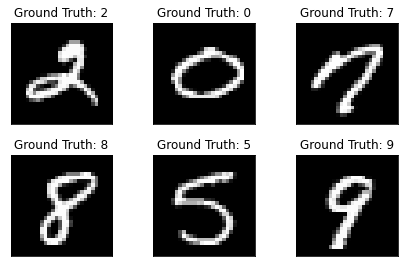

In [13]:
# 绘制数字图片
fig = plt.figure()
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()

In [20]:
# https://www.yingsoo.com/news/devops/69001.html
def one_hot(label, depth=10):
    out = torch.zeros(label.size(0), depth)
    idx = torch.LongTensor(label).view(-1, 1)
    out.scatter_(dim=1, index=idx, value=1)
    return out
# https://www.yingsoo.com/news/devops/69001.html
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #xw+b
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 64)
        #输出层
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        # x的维度索引:[i,1,28,28]
        # 计算过程
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
#梯度下降优化器
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
train_loss = []
for epoch in range(3):
    for batch_idx, (x, y) in enumerate(train_loader):
        # print(batch_idx,x.shape,y.shape)
        # x的维度是[512,1,28,28]
        # x.size(0)=512，x.size(1)=1，就是取出x的维度信息
        # 将x的shape进行转换，[512,1,28,28]=>[512,28*28]
        x = x.view(x.size(0), 28 * 28)
        #相当于调用了forward函数，out就是输出的10维label
        out = net(x)
        # https://www.jb51.net/article/273935.htm
        y_onehot=one_hot(y)
        loss = F.mse_loss(out, y_onehot)
        optimizer.zero_grad()
        loss.backward()
        # 更新优化w'，即w' = w - lr*grad
        optimizer.step()
        train_loss.append(loss.item())
        # 每10个batch输出一次loss结果
        if batch_idx % 10 == 0:
            print(epoch, batch_idx, loss.item())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


KeyboardInterrupt: 